# **Supply Chain Analysis**

**Task:** Assign routes to the Orders in the 'OrdersList' table given the restrictions: 
1.  some customers can only be serviced by a particular plant
2.  plants and ports have to be physically connected
3.  plants can only handle specific items

This dataset is divided into 7 tables.

1. The OrderList table contains historical records of how the orders were routed and demand satisfied.  Order ID is the ID of the order made by the customer, and Product ID is the specific product ID the customer ordered.
2. The FreightRates table describes all available carriers, the weight gaps for each individual lane and rates associated.  "tpt_day_cnt" means transportation day count, i.e. estimated shipping time.
3. The WhCosts table specifies the cost associated in storing the products in a given warehouse measured in dollars per unit.
4. The WhCapacities table lists warehouse capacities measured in number of orders per day.  WhCapacities corresponds to the number of orders. For example, let's say Customer 1 requests 10 units of X, Customer 2 requests 20 units of Y. The total number of orders is 2, thus total capacity in "WhCapacities" is 2.  The table shows the maximum number of orders that can be processed per day for each plant - it is not dependent on specific products.
5. The ProductsPerPlant table lists all supported warehouse-product combinations.
6. The VmiCustomers lists all special cases, where the warehouse is only allowed to support a specific customer, while any other non-listed warehouse can supply any customer.
7. The PlantPorts table describes the allowed links between the warehouses and shipping ports. 

In order to build a Linear Programming (LP) model, you would take the following from the OrderList: the Product ID that needs to be shipped, the Destination Port, Unit quantity and Weight (for weight constraints). And then use the limits of those constraints from other tables.

Notes: There is a Carrier V44_3 in the order_list table, but it is missing in the FreightRates table. V44_3 is a carrier that was historically used for supplying given demand, but it has been discontinued and therefore does not appear in the Freight Rates List. Also, all of the V44_3 instances are CRF - i.e. customer arranges their own shipping and hence cost is not calculated either way.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

1. load excel file
2. read all sheets into a dictionary of dataframes
3. show all keys (sheet names)

In [10]:
main_file = pd.ExcelFile("/Users/timothypark/Documents/portfolios/timpark99.github.io/supply chain analysis/supply chain original.xlsx")

df_dict = {sheet_name: main_file.parse(sheet_name) for sheet_name in main_file.sheet_names}

df_dict.keys()

dict_keys(['OrderList', 'FreightRates', 'WhCosts', 'WhCapacities', 'ProductsPerPlant', 'VmiCustomers', 'PlantPorts'])

## Data Preparation and Transformation
1. print the shape of each dataframe
2. check and print duplicates or missing values for each dataframe

* df.duplicated().sum() calculates the total number of duplicate rows.
* df.isnull().sum().sum() finds the total number of missing values across all columns.  There are two calls for .sum() because the first one looks at each column, but the second call adds up all the missing value counts from all columns.  

In [12]:
for df_name, df in df_dict.items():
    print(f"{df_name} - Shape: {df.shape}")
    
    duplicate_count = df.duplicated().sum()
    missing_values_count = df.isnull().sum().sum()
    
    if duplicate_count > 0 or missing_values_count > 0:
        print(f"   >>> {df_name} - Duplicates: {duplicate_count}; Missing Values: {missing_values_count}")
    else:
        print(f"   >>> {df_name} has no duplicates or missing values.")

OrderList - Shape: (9215, 14)
   >>> OrderList has no duplicates or missing values.
FreightRates - Shape: (1540, 11)
   >>> FreightRates - Duplicates: 3; Missing Values: 0
WhCosts - Shape: (19, 2)
   >>> WhCosts has no duplicates or missing values.
WhCapacities - Shape: (19, 2)
   >>> WhCapacities has no duplicates or missing values.
ProductsPerPlant - Shape: (2036, 2)
   >>> ProductsPerPlant has no duplicates or missing values.
VmiCustomers - Shape: (14, 2)
   >>> VmiCustomers has no duplicates or missing values.
PlantPorts - Shape: (22, 2)
   >>> PlantPorts has no duplicates or missing values.


1. drop duplicates for the FreightRates table
2. update dictionary
3. rename columns by replacing spaces and `/` with underscores and make them all uppercase.  The .strip() method removes any leading or trailing whitespace from each column name.

In [14]:
FreightRates = df_dict['FreightRates'].drop_duplicates()

df_dict['FreightRates'] = FreightRates

for df_name, df in df_dict.items():
    df.columns = [col.strip().replace(' ', '_').replace('/', '_').upper() for col in df.columns]

print(df_dict['OrderList'].columns)

Index(['ORDER_ID', 'ORDER_DATE', 'ORIGIN_PORT', 'CARRIER', 'TPT',
       'SERVICE_LEVEL', 'SHIP_AHEAD_DAY_COUNT', 'SHIP_LATE_DAY_COUNT',
       'CUSTOMER', 'PRODUCT_ID', 'PLANT_CODE', 'DESTINATION_PORT',
       'UNIT_QUANTITY', 'WEIGHT'],
      dtype='object')


* merge OrderList with FreightRates and WhCosts on relevant columns: here we set a variable orderList to be the OrderList dataframe.  Then we first merge the OrderList and FreightRates dataframes, using matching columns as join keys.  We merge on 3 key columns which are CARRIER, ORIGIN_PORT, and DESTINATION_PORT in OrderList, which correspond to CARRIER, ORIG_PORT_CD, and DEST_PORT_CD in FreightRates. how='left' ensures that all rows in orderList are kept, with matched values from FreightRates or NaN if no match is found.  Then we merge orderList with WhCosts on the PLANT_CODE column in orderList and WH in WhCosts.  Again, how='left' retains all rows from orderList, adding WhCosts data where available.
* calculate the cost by multiplying unit quantity with the shipping rate and adding the storage cost: we add a new column in orderList called **COST** and we add up the cost of transporting the order and the cost of storing it in the warehouse by using the variables UNIT_QUANTITY, RATE, and COST_UNIT.
* perform detailed data preparation and transformation for OrderList dataframe: In these lines, you’re cleaning up orderList by dropping rows with any NaN values and converting the ORDER_DATE column to a datetime format.  This allows for easier manipulation of date-related data, such as filtering, grouping by date, or calculating time differences.
This is a common data-preprocessing step to ensure data is complete and dates are in the correct format for analysis.
* perform additional data preparation and transformation for the ProductsPerPlant dataframe
* update dictionary values with the cleaned dataframes 


In [16]:
orderList = df_dict['OrderList']

orderList = orderList.merge(df_dict['FreightRates'], left_on=['CARRIER', 'ORIGIN_PORT', 'DESTINATION_PORT'],
                            right_on=['CARRIER', 'ORIG_PORT_CD', 'DEST_PORT_CD'], how='left')

orderList = orderList.merge(df_dict['WhCosts'], left_on='PLANT_CODE', right_on='WH', how='left')

orderList['COST'] = (orderList['UNIT_QUANTITY'] * orderList['RATE']) + (orderList['UNIT_QUANTITY'] * orderList['COST_UNIT'])

orderList = orderList.dropna()

orderList['ORDER_DATE'] = pd.to_datetime(orderList['ORDER_DATE'])

productsPerPlant = df_dict['ProductsPerPlant']
productsPerPlant = productsPerPlant.dropna()

df_dict['OrderList'] = orderList
df_dict['ProductsPerPlant'] = productsPerPlant

df_dict['OrderList'].head()

ORDER_ID ORDER_DATE ORIGIN_PORT CARRIER  TPT SERVICE_LEVEL  \
854  1.447385e+09 2013-05-26      PORT09  V444_0    0           DTP   
855  1.447385e+09 2013-05-26      PORT09  V444_0    0           DTP   
856  1.447338e+09 2013-05-26      PORT09  V444_0    0           DTP   
857  1.447338e+09 2013-05-26      PORT09  V444_0    0           DTP   
858  1.447407e+09 2013-05-26      PORT09  V444_0    0           DTP   

     SHIP_AHEAD_DAY_COUNT  SHIP_LATE_DAY_COUNT   CUSTOMER  PRODUCT_ID  ...  \
854                     0                    0   V55555_4     1692724  ...   
855                     0                    0   V55555_4     1692724  ...   
856                     0                    0   V55555_4     1692724  ...   
857                     0                    0   V55555_4     1692724  ...   
858                     3                    0  V555555_6     1692722  ...   

    MAX_WGH_QTY SVC_CD  MINIMUM_COST     RATE MODE_DSC TPT_DAY_CNT  \
854      5000.0    DTP       31.2784  12.2784   GROUND         0.0   
855      5000.0    DTD       31.2784  13.2784   GROUND         0.0   
856      5000.0    DTP       31.2784  12.2784   GROUND         0.0   
857      5000.0    DTD       31.2784  13.2784   GROUND         0.0   
858      5000.0    DTP       31.2784  12.2784   GROUND         0.0   

     CARRIER_TYPE       WH COST_UNIT         COST  
854   V88888888_0  PLANT16  1.919808  4713.804893  
855   V88888888_0  PLANT16  1.919808  5045.804893  
856   V88888888_0  PLANT16  1.919808  5082.958288  
857   V88888888_0  PLANT16  1.919808  5440.958288  
858   V88888888_0  PLANT16  1.919808  5807.066871  

[5 rows x 27 columns]

In [17]:
print(df_dict['OrderList']['SERVICE_LEVEL'].unique())
print(df_dict['OrderList']['SVC_CD'].unique())
print(df_dict['OrderList']['PLANT_CODE'].unique())
print(df_dict['OrderList']['WH'].unique())

['DTP' 'DTD']
['DTP' 'DTD']
['PLANT16' 'PLANT12' 'PLANT09' 'PLANT03' 'PLANT13' 'PLANT08']
['PLANT16' 'PLANT12' 'PLANT09' 'PLANT03' 'PLANT13' 'PLANT08']


* check updated columns of all dataframes

In [19]:
for df_name, df in df_dict.items():
    print(f'Dataframe: {df_name} >>>')
    print('Columns:', df.columns.values)

Dataframe: OrderList >>>
Columns: ['ORDER_ID' 'ORDER_DATE' 'ORIGIN_PORT' 'CARRIER' 'TPT' 'SERVICE_LEVEL'
 'SHIP_AHEAD_DAY_COUNT' 'SHIP_LATE_DAY_COUNT' 'CUSTOMER' 'PRODUCT_ID'
 'PLANT_CODE' 'DESTINATION_PORT' 'UNIT_QUANTITY' 'WEIGHT' 'ORIG_PORT_CD'
 'DEST_PORT_CD' 'MINM_WGH_QTY' 'MAX_WGH_QTY' 'SVC_CD' 'MINIMUM_COST'
 'RATE' 'MODE_DSC' 'TPT_DAY_CNT' 'CARRIER_TYPE' 'WH' 'COST_UNIT' 'COST']
Dataframe: FreightRates >>>
Columns: ['CARRIER' 'ORIG_PORT_CD' 'DEST_PORT_CD' 'MINM_WGH_QTY' 'MAX_WGH_QTY'
 'SVC_CD' 'MINIMUM_COST' 'RATE' 'MODE_DSC' 'TPT_DAY_CNT' 'CARRIER_TYPE']
Dataframe: WhCosts >>>
Columns: ['WH' 'COST_UNIT']
Dataframe: WhCapacities >>>
Columns: ['PLANT_ID' 'DAILY_CAPACITY']
Dataframe: ProductsPerPlant >>>
Columns: ['PLANT_CODE' 'PRODUCT_ID']
Dataframe: VmiCustomers >>>
Columns: ['PLANT_CODE' 'CUSTOMERS']
Dataframe: PlantPorts >>>
Columns: ['PLANT_CODE' 'PORT']


## Statistics and Visualization

The .describe() function in Python is a quick and powerful way to generate summary statistics for numerical and categorical columns in a pandas DataFrame.  df.describe() generates descriptive statistics for all numeric columns by default.  Notice how it doesn't contain any text values.

Statistics include:
* count: Number of non-missing values.
* mean: Average of the column.
* std: Standard deviation.
* min: Minimum value.
* 25%, 50%, 75%: Percentiles (Quartiles).
* max: Maximum value.

In [22]:
df_dict['OrderList'].describe()

ORDER_ID           ORDER_DATE            TPT  SHIP_AHEAD_DAY_COUNT  \
count  2.085480e+05               208548  208548.000000         208548.000000   
mean   1.447273e+09  2013-05-26 00:00:00       1.624374              1.931987   
min    1.447126e+09  2013-05-26 00:00:00       0.000000              0.000000   
25%    1.447195e+09  2013-05-26 00:00:00       1.000000              0.000000   
50%    1.447273e+09  2013-05-26 00:00:00       2.000000              1.000000   
75%    1.447345e+09  2013-05-26 00:00:00       2.000000              3.000000   
max    1.447425e+09  2013-05-26 00:00:00       3.000000              6.000000   
std    8.414006e+04                  NaN       0.496295              2.059308   

       SHIP_LATE_DAY_COUNT    PRODUCT_ID  UNIT_QUANTITY         WEIGHT  \
count        208548.000000  2.085480e+05  208548.000000  208548.000000   
mean              0.037881  1.680153e+06    2664.160021      16.350336   
min               0.000000  1.613321e+06     235.000000       0.000000   
25%               0.000000  1.671942e+06     328.000000       1.404421   
50%               0.000000  1.683634e+06     437.000000       4.484133   
75%               0.000000  1.689547e+06     955.000000      13.080000   
max               6.000000  1.702224e+06  561847.000000    2338.405126   
std               0.313074  1.450609e+04   14966.032979      49.284847   

        MINM_WGH_QTY    MAX_WGH_QTY   MINIMUM_COST           RATE  \
count  208548.000000  208548.000000  208548.000000  208548.000000   
mean      420.013605   12770.395519       9.900351       0.132569   
min         0.000000       0.500000       1.202000       0.042400   
25%         1.510000      99.990000       1.499200       0.048400   
50%       100.000000     299.990000       3.455200       0.056400   
75%       500.000000    1999.990000       3.455200       0.082400   
max      2000.000000   99999.990000     101.827200      13.278400   
std       628.169544   32193.967016      21.315896       0.272103   

         TPT_DAY_CNT      COST_UNIT           COST  
count  208548.000000  208548.000000  208548.000000  
mean        2.096975       0.527681    1597.678289  
min         0.000000       0.465071     122.905694  
25%         2.000000       0.517502     202.688741  
50%         2.000000       0.517502     305.286643  
75%         3.000000       0.517502     634.937701  
max         3.000000       1.919808  337053.078104  
std         0.701241       0.056108    8684.093299

In [23]:
df_dict['FreightRates'].describe()

MINM_WGH_QTY   MAX_WGH_QTY  MINIMUM_COST         RATE  TPT_DAY_CNT
count   1537.000000   1537.000000   1537.000000  1537.000000  1537.000000
mean     156.190905   4635.433438     12.300002     2.875135     2.188679
std      476.366708  20271.070359     22.959164     4.590475     2.002161
min        0.000000      0.453592      1.202000     0.033200     0.000000
25%       15.010000     21.500000      3.656800     0.451200     1.000000
50%       41.281408     47.500000      7.403200     1.656800     2.000000
75%       67.510000     75.000000     11.480000     3.916800     2.000000
max    10000.000000  99999.990000    425.027200   128.027200    14.000000

* .corr():
Calculates pairwise correlation coefficients for numeric columns in the DataFrame.
By default, the method used is Pearson correlation, which measures the linear relationship between two variables.

* numeric_only=True:
Ensures that only numeric columns in the DataFrame are included in the correlation calculation.
This avoids errors or unexpected results when the DataFrame contains non-numeric data types.

* .round(2):
Rounds all the correlation values to two decimal places for better readability.

Interpreting the Correlation Matrix:<br>
Diagonal Values: Always 1.0, as a column is perfectly correlated with itself.<br>
Off-Diagonal Values: Positive values (close to 1): Strong positive linear relationship.<br>
Negative values (close to -1): Strong negative linear relationship.<br>
Values near 0: Weak or no linear relationship.

In [25]:
correlation_matrix = df_dict['OrderList'].corr(numeric_only=True).round(2)
correlation_matrix

ORDER_ID   TPT  SHIP_AHEAD_DAY_COUNT  \
ORDER_ID                  1.00 -0.02                 -0.03   
TPT                      -0.02  1.00                 -0.13   
SHIP_AHEAD_DAY_COUNT     -0.03 -0.13                  1.00   
SHIP_LATE_DAY_COUNT      -0.03  0.06                 -0.02   
PRODUCT_ID                0.03 -0.23                  0.08   
UNIT_QUANTITY             0.01  0.15                 -0.07   
WEIGHT                    0.00  0.09                 -0.01   
MINM_WGH_QTY             -0.01  0.28                 -0.05   
MAX_WGH_QTY              -0.01  0.28                 -0.05   
MINIMUM_COST              0.01 -0.40                  0.07   
RATE                      0.01 -0.37                  0.06   
TPT_DAY_CNT              -0.02  0.66                 -0.11   
COST_UNIT                -0.01  0.10                  0.08   
COST                      0.01  0.13                 -0.07   

                      SHIP_LATE_DAY_COUNT  PRODUCT_ID  UNIT_QUANTITY  WEIGHT  \
ORDER_ID                            -0.03        0.03           0.01    0.00   
TPT                                  0.06       -0.23           0.15    0.09   
SHIP_AHEAD_DAY_COUNT                -0.02        0.08          -0.07   -0.01   
SHIP_LATE_DAY_COUNT                  1.00       -0.04          -0.01   -0.01   
PRODUCT_ID                          -0.04        1.00           0.03   -0.04   
UNIT_QUANTITY                       -0.01        0.03           1.00    0.43   
WEIGHT                              -0.01       -0.04           0.43    1.00   
MINM_WGH_QTY                         0.02       -0.06           0.03    0.02   
MAX_WGH_QTY                          0.02       -0.06           0.03    0.02   
MINIMUM_COST                        -0.03        0.09          -0.04   -0.02   
RATE                                -0.02        0.09          -0.03    0.02   
TPT_DAY_CNT                          0.05       -0.15           0.06    0.04   
COST_UNIT                           -0.02       -0.09          -0.03    0.05   
COST                                -0.01        0.03           0.99    0.43   

                      MINM_WGH_QTY  MAX_WGH_QTY  MINIMUM_COST  RATE  \
ORDER_ID                     -0.01        -0.01          0.01  0.01   
TPT                           0.28         0.28         -0.40 -0.37   
SHIP_AHEAD_DAY_COUNT         -0.05        -0.05          0.07  0.06   
SHIP_LATE_DAY_COUNT           0.02         0.02         -0.03 -0.02   
PRODUCT_ID                   -0.06        -0.06          0.09  0.09   
UNIT_QUANTITY                 0.03         0.03         -0.04 -0.03   
WEIGHT                        0.02         0.02         -0.02  0.02   
MINM_WGH_QTY                  1.00         0.94          0.16 -0.19   
MAX_WGH_QTY                   0.94         1.00         -0.08 -0.12   
MINIMUM_COST                  0.16        -0.08          1.00 -0.06   
RATE                         -0.19        -0.12         -0.06  1.00   
TPT_DAY_CNT                   0.20         0.21         -0.30 -0.28   
COST_UNIT                    -0.02        -0.02          0.03  0.40   
COST                          0.02         0.02         -0.04 -0.01   

                      TPT_DAY_CNT  COST_UNIT  COST  
ORDER_ID                    -0.02      -0.01  0.01  
TPT                          0.66       0.10  0.13  
SHIP_AHEAD_DAY_COUNT        -0.11       0.08 -0.07  
SHIP_LATE_DAY_COUNT          0.05      -0.02 -0.01  
PRODUCT_ID                  -0.15      -0.09  0.03  
UNIT_QUANTITY                0.06      -0.03  0.99  
WEIGHT                       0.04       0.05  0.43  
MINM_WGH_QTY                 0.20      -0.02  0.02  
MAX_WGH_QTY                  0.21      -0.02  0.02  
MINIMUM_COST                -0.30       0.03 -0.04  
RATE                        -0.28       0.40 -0.01  
TPT_DAY_CNT                  1.00      -0.07  0.05  
COST_UNIT                   -0.07       1.00 -0.02  
COST                         0.05      -0.02  1.00

* plt.figure(figsize=(10, 6)): Initializes a new figure for the plot with a specified size of 10 inches wide and 6 inches tall.
* sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm'): annot=True: Displays the correlation values inside the heatmap cells.  cmap='coolwarm': Sets the color map for the heatmap. Colors range from cool (blue) for negative correlations to warm (red) for positive correlations.
* plt.show(): Displays the heatmap.

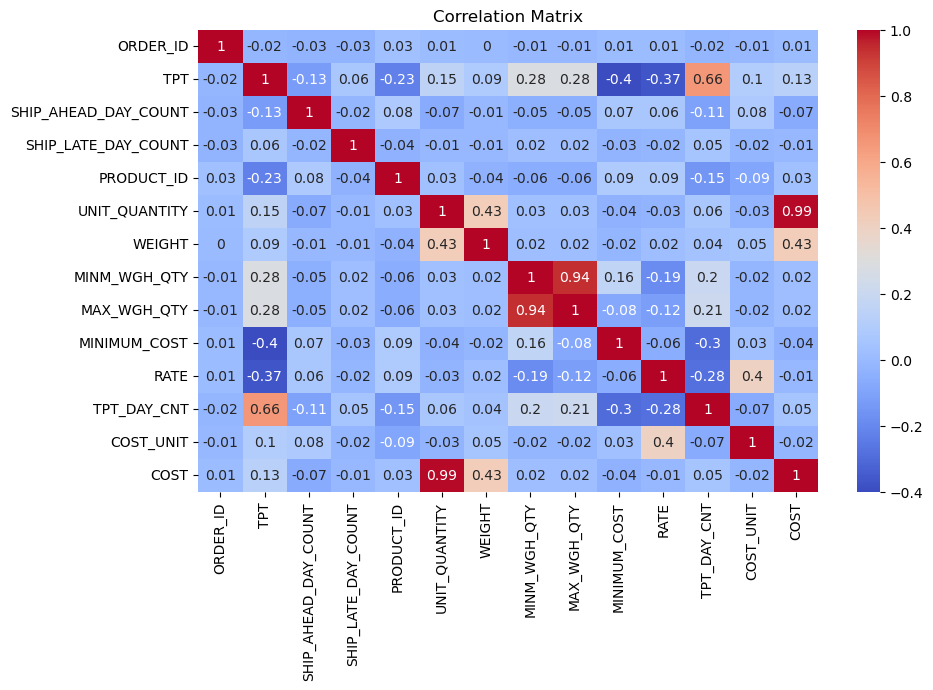

In [27]:
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

* pricing_strategy = df_dict['FreightRates']['MODE_DSC'].unique():  Extracts the unique values in the MODE_DSC column of the FreightRates DataFrame in order to identify the different pricing strategies or transportation modes.
* price_elasticity = df_dict['FreightRates']['RATE'].mean():  Computes the average value of the RATE column in the FreightRates DataFrame.
* historical_revenue = df_dict['OrderList']['UNIT_QUANTITY'] * df_dict['OrderList']['COST']:  Multiplies the UNIT_QUANTITY column by the COST column in the OrderList DataFrame for each row in order to calculate revenue generated for each order historically.

In [29]:
pricing_strategy = df_dict['FreightRates']['MODE_DSC'].unique()
price_elasticity = df_dict['FreightRates']['RATE'].mean()
historical_revenue = df_dict['OrderList']['UNIT_QUANTITY']*df_dict['OrderList']['COST']
total_revenue = historical_revenue.sum()

print("Pricing strategies:", pricing_strategy)
print("Average price elasticity:", price_elasticity)
print("Total historical revenue:", total_revenue)


Pricing strategies: ['AIR   ' 'GROUND']
Average price elasticity: 2.875135211279718
Total historical revenue: 27855522352652.188


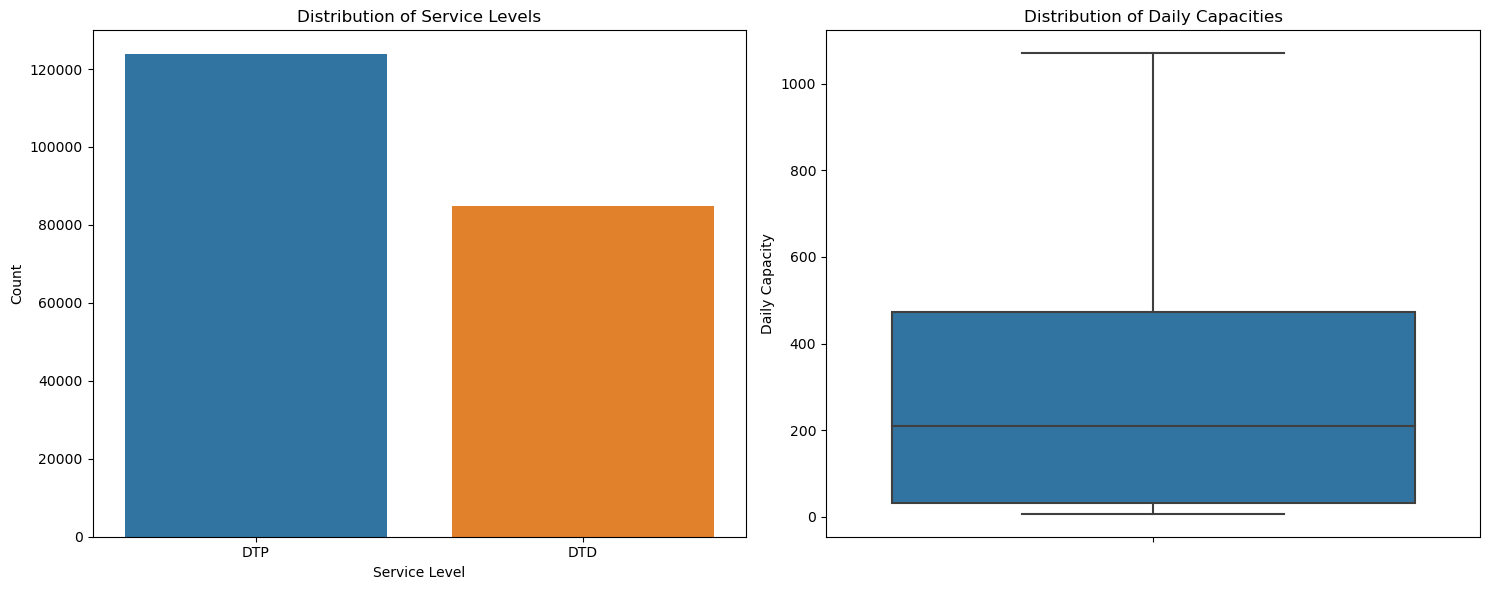

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))
sns.countplot(data=df_dict['OrderList'], x='SERVICE_LEVEL', ax=axes[0])
axes[0].set_title('Distribution of Service Levels')
axes[0].set_xlabel('Service Level')
axes[0].set_ylabel('Count')

sns.boxplot(data=df_dict['WhCapacities'], y='DAILY_CAPACITY', ax=axes[1])
axes[1].set_title('Distribution of Daily Capacities')
axes[1].set_ylabel('Daily Capacity')

plt.tight_layout()
plt.show()

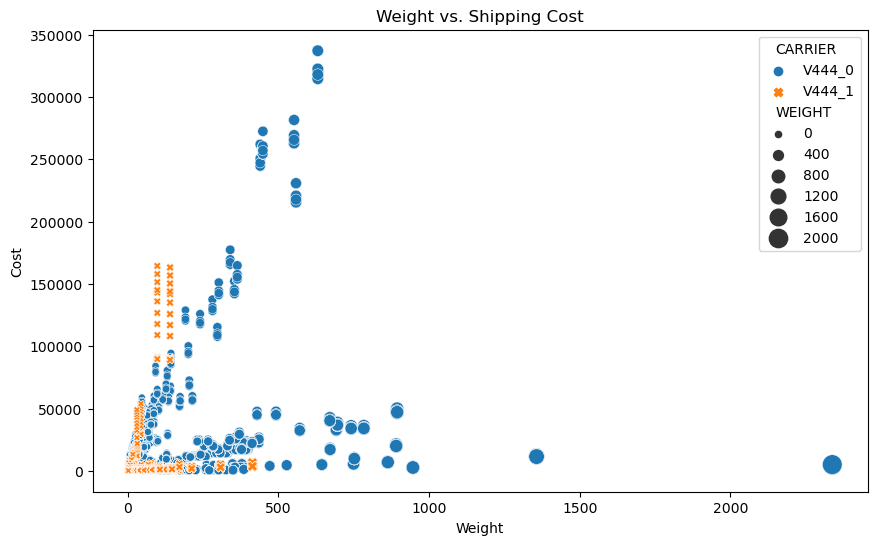

In [31]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_dict['OrderList'], x='WEIGHT', y='COST', hue='CARRIER', size='WEIGHT', sizes=(20, 200), style='CARRIER')
plt.title('Weight vs. Shipping Cost')
plt.xlabel('Weight')
plt.ylabel('Cost')
plt.show()

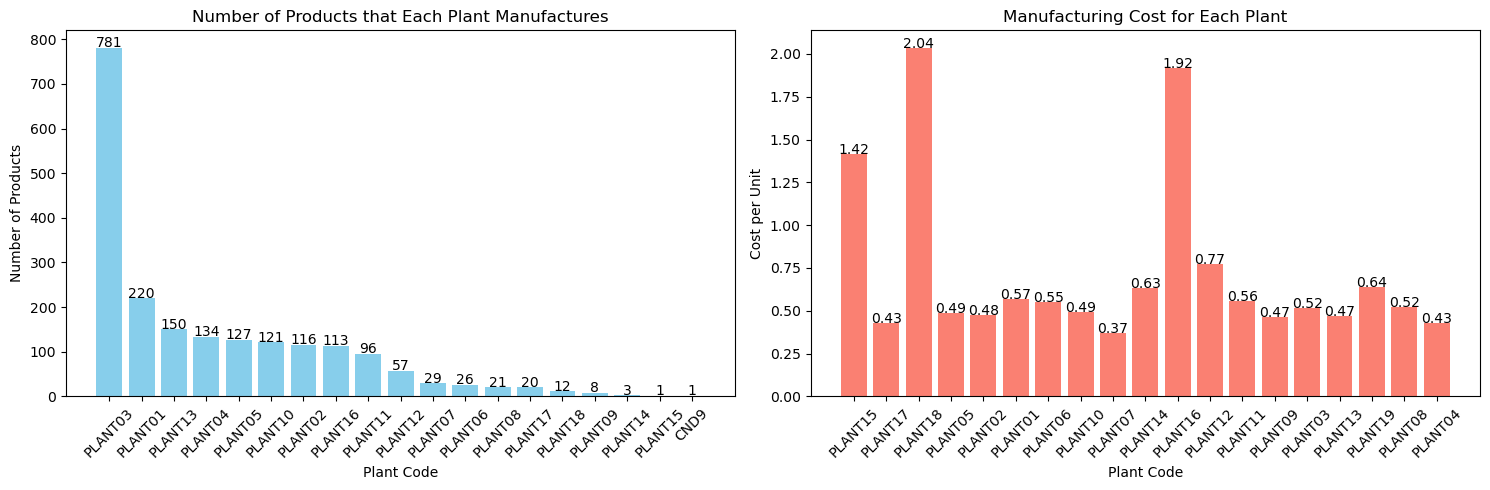

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plant_counts = df_dict['ProductsPerPlant']['PLANT_CODE'].value_counts()
axes[0].bar(plant_counts.index, plant_counts.values, color='skyblue')
for i, value in enumerate(plant_counts.values):
    axes[0].text(i, value+1, str(value), ha='center', fontsize=10)
axes[0].set_title('Number of Products that Each Plant Manufactures')
axes[0].set_xlabel('Plant Code')
axes[0].set_ylabel('Number of Products')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(df_dict['WhCosts']['WH'], df_dict['WhCosts']['COST_UNIT'], color='salmon')
for i, value in enumerate(df_dict['WhCosts']['COST_UNIT']):
    axes[1].text(i, value, f"{value:.2f}", ha='center', fontsize=10)
    
axes[1].set_title('Manufacturing Cost for Each Plant')
axes[1].set_xlabel('Plant Code')
axes[1].set_ylabel('Cost per Unit')
axes[1]. tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
                  
                

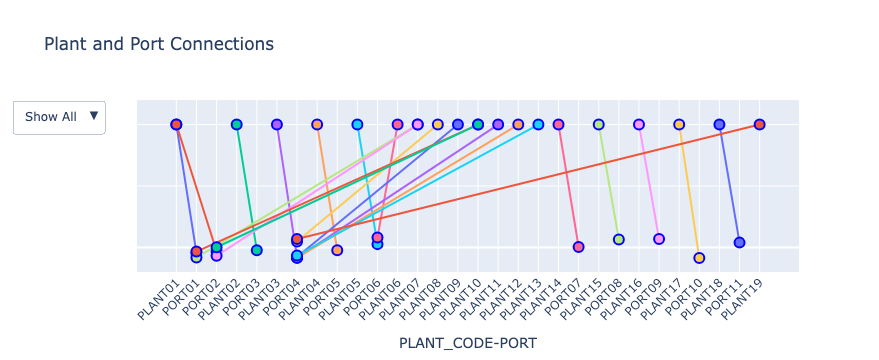

In [33]:
import plotly.graph_objects as go

df_plant_ports = df_dict['PlantPorts']
fig = go.Figure()

for _, row in df_plant_ports.iterrows():
    fig.add_trace(
        go.Scatter(
            x = [row['PLANT_CODE'], row['PORT']],
            y = [1, 0 +np.random.uniform(-0.1, 0.1)],
            mode = 'lines+markers',
            marker=dict(
                size=10,
                symbol = 'circle',
                line = dict(
                    color='blue',
                    width=2
                )
            ),
            hoverinfo = 'text',
            text = f"Plant:{row['PLANT_CODE']}<br>Port: {row['PORT']}"
        )
    )

fig.update_layout(
    title_text = 'Plant and Port Connections',
    showlegend=False,
    xaxis=dict(
        title='PLANT_CODE-PORT',
        tickangle=-45
    ),
    yaxis=dict(
        title='',
        showticklabels=False,
        range=[-.2, 1.2]
    ),
    updatemenus=[
        dict(
            buttons=[
                dict(
                    label='Show All',
                    method='update',
                    args=[{'visible':[True]*len(df_plant_ports)},
                          {'title': 'All Plant-Port Connections'}]
                ),
                dict(
                    label='Filter by Port 01',
                    method='update',
                    args=[{'visible':[row['PORT']=='PORT01' for _, row in df_plant_ports.iterrows()]},
                          {'title': 'Connections for Port 01'}]
                )

                
                
            ],
            type='dropdown',
            showactive=True,
            direction='down'
        )
    ]
)

fig.show()
            